In [38]:
from datetime import date

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from scipy.special import gamma, gammaincc, betainc
from scipy.integrate import quad
import math

Get hashrate data from NASDAQ API:

In [2]:
hr_response = requests.get('https://data.nasdaq.com/api/v3/datasets/BCHAIN/HRATE.json?api_key=CEZ47Us4M6dvsFYzReoG')
hr_data = hr_response.json()['dataset']['data']
hr_df = pd.DataFrame.from_records(hr_data, columns=['Date', 'Hashrate'])
hr_df['Day'] = list(reversed(range(0, len(hr_df.index))))
hr_df.sort_values(by='Day', ascending=True, inplace=True)
hr_df.reset_index(drop=True, inplace=True)
hr_df = hr_df[['Date', 'Day', 'Hashrate']]
hr_df['Date'] = pd.to_datetime(hr_df['Date'])
hr_df['Hashrate (Raw)'] = hr_df['Hashrate']*1000000000000
hr_df['Hashrate (Exa)'] = hr_df['Hashrate (Raw)'] / 1e18
hr_df

,Date,Day,Hashrate,Hashrate (Raw),Hashrate (Exa)
0,2009-01-03,0,0.000000e+00,0.000000e+00,0.000000
1,2009-01-04,1,0.000000e+00,0.000000e+00,0.000000
2,2009-01-05,2,0.000000e+00,0.000000e+00,0.000000
3,2009-01-06,3,0.000000e+00,0.000000e+00,0.000000
4,2009-01-07,4,0.000000e+00,0.000000e+00,0.000000
...,...,...,...,...,...
5060,2022-11-11,5060,2.448795e+08,2.448795e+20,244.879481
5061,2022-11-12,5061,3.051856e+08,3.051856e+20,305.185622
5062,2022-11-13,5062,2.357422e+08,2.357422e+20,235.742187
5063,2022-11-14,5063,2.247774e+08,2.247774e+20,224.777434


Extract only 2021 data and calculate day-to-day difference in hashrate:

In [13]:
index_2021_plus = hr_df[pd.to_datetime(date(2021,1,1)) < hr_df['Date']].index
hr_df_2021_plus = hr_df.loc[index_2021_plus, ['Date', 'Hashrate (Exa)']]
index_2021 = hr_df_2021_plus[hr_df_2021_plus['Date'] < pd.to_datetime(date(2022,1,1))].index
hr_df_2021 = hr_df_2021_plus.loc[index_2021, :]
hr_df_2021['change'] = hr_df_2021['Hashrate (Exa)'].pct_change()
hr_df_2021

,Date,Hashrate (Exa),change
4382,2021-01-02,139.613209,NaN
4383,2021-01-03,146.085344,0.046358
4384,2021-01-04,159.954206,0.094937
4385,2021-01-05,145.160753,-0.092486
4386,2021-01-06,163.652569,0.127389
...,...,...,...
4741,2021-12-27,178.574457,0.104478
4742,2021-12-28,161.682279,-0.094595
4743,2021-12-29,174.954704,0.082090
4744,2021-12-30,143.583516,-0.179310


Identify largest 1-day drop in hashrate:

In [22]:
maxdrop_ind = hr_df_2021['change'].idxmin()
maxdrop = hr_df_2021.loc[maxdrop_ind, :]
maxdrop

Date              2021-04-16 00:00:00
Hashrate (Exa)             120.743466
change                      -0.391763
Name: 4486, dtype: object

Create a plot annotating the largest drop:

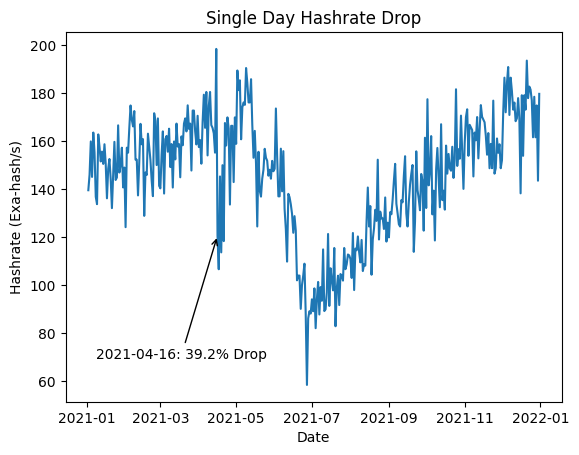

In [26]:
fig, ax = plt.subplots(1, 1)

ax.plot(hr_df_2021['Date'], hr_df_2021['Hashrate (Exa)'])
ax.annotate(
    f'{maxdrop["Date"].date()}: {round(maxdrop["change"]*(-100), 1)}% Drop',
    xy=(maxdrop['Date'], maxdrop['Hashrate (Exa)']),
    xycoords='data',
    xytext=(0.15, 0.2),
    textcoords='figure fraction',
    arrowprops=dict(arrowstyle='->')
)

plt.title('Single Day Hashrate Drop')
plt.xlabel('Date')
plt.ylabel('Hashrate (Exa-hash/s)')
plt.savefig('dailydrop.png')
plt.show()

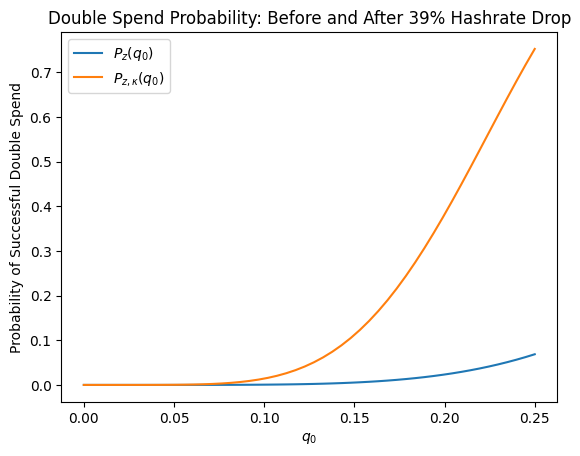

In [46]:
q_0 = np.linspace(0, 0.25)
p_0 = 1 - q_0
q_1 = 1.639*q_0
p_1 = 1 - q_1
z = 6
k = 1.39

pz = betainc(z, 0.5, 4*q_0*(p_0))
pzk = 1 - gammaincc(z, (k*z*q_1)/p_1) + ((q_1/p_1)**z)*np.exp(k*z*(p_1 - q_1)/p_1)*gammaincc(z, k*z)

fig, ax = plt.subplots(1, 1)

ax.plot(q_0, pz, label='$P_z(q_0)$')
ax.plot(q_0, pzk, label='$P_{z,\kappa}(q_0)$')

plt.legend()
plt.title('Double Spend Probability: Before and After 39% Hashrate Drop')
plt.xlabel('$q_0$')
plt.ylabel('Probability of Successful Double Spend')
plt.savefig('pcompare2021.png')
plt.show()

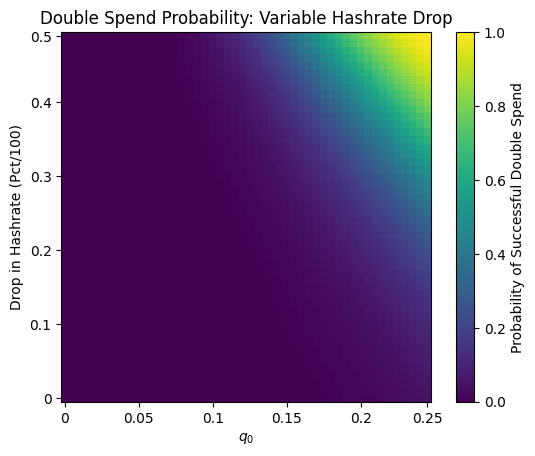

In [65]:
def calc_pzk(q_0, drop_pct):
    z = 6
    k = 1 + drop_pct

    q_1 = (1/(1 - drop_pct))*q_0
    p_1 = 1 - q_1

    pzk = 1 - gammaincc(z, (k*z*q_1)/p_1) + ((q_1/p_1)**z)*np.exp(k*z*(p_1 - q_1)/p_1)*gammaincc(z, k*z)
    return pzk
    
q_0_arr = np.linspace(0, 0.25)
drop_arr = np.linspace(0, 0.5)
X,Y = np.meshgrid(q_0_arr, drop_arr)
pzk_grid = calc_pzk(X, Y)

fig, ax = plt.subplots(1, 1)
im = ax.imshow(pzk_grid, origin='lower')

plt.title('Double Spend Probability: Variable Hashrate Drop')
plt.xticks([0, 10, 20, 30, 40, 49], [0, 0.05, 0.1, 0.15, 0.2, 0.25])
plt.yticks([0, 10, 20, 30, 40, 49], [0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.colorbar(im, label='Probability of Successful Double Spend')
plt.xlabel('$q_0$')
plt.ylabel('Drop in Hashrate (Pct/100)')
plt.savefig('pvariabledrop.png')
plt.show()

In [59]:
calc_pzk(0.25, 0.5)

1.0